In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

import xgboost as xgb
root = 'C:/Data/instacart-market-basket-analysis/'

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [2]:
aisles = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\aisles.csv')
departments = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\departments.csv')
orders = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\orders.csv')
order_products_prior = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\order_products__prior.csv')
order_products_train = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\order_products__train.csv')
products = pd.read_csv(r'C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\data\products.csv')

In [3]:
product_orders = orders.merge(order_products_prior, on='order_id', how='inner') 
product_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [4]:
# Create a customer/user dataframe
# ID highest order # in each of these groups
# Save column into a dataframe

user = product_orders.groupby('user_id')['order_number'].max().to_frame('c_total_orders')

user.head(2)


,c_total_orders
user_id,
1,10
2,14


In [5]:
# prob reordered = 
## (total times of reorder) / (total # of ordered products)

# (total times of reorder) : all the times customer has reordered
# (total # of ordered products) : products that have been purchased; binary reorder value (0,1)

# 'reordered' info from 'order_products_prior'('po')
# Calculate mean of reordered

c_reorder = product_orders.groupby('user_id')['reordered'].mean().to_frame('c_reordered_ratio')

# c_reorder = c_reorder.reset_index()

c_reorder.head()

,c_reordered_ratio
user_id,
1,0.694915
2,0.476923
3,0.625000
4,0.055556
5,0.378378


In [6]:
dow = product_orders.groupby('user_id')['order_dow'].mean().to_frame('average_dow')

dow.head()

,average_dow
user_id,
1,2.644068
2,2.005128
3,1.011364
4,4.722222
5,1.621622


In [7]:
user = user.merge(c_reorder, on='user_id', how='left')

user.head()

,c_total_orders,c_reordered_ratio
user_id,,
1,10,0.694915
2,14,0.476923
3,12,0.625000
4,5,0.055556
5,4,0.378378


In [8]:
user = user.merge(dow, on='user_id', how='left')

user.head()

,c_total_orders,c_reordered_ratio,average_dow
user_id,,,
1,10,0.694915,2.644068
2,14,0.476923,2.005128
3,12,0.625000,1.011364
4,5,0.055556,4.722222
5,4,0.378378,1.621622


Product Predictors
<br/>
    1. Number of Purchases for Each Product
<br/>
    2. Probability for a Product to be Reordered

In [9]:
# Create product dataframe to store results
# Total number of purchases (count)

prod = product_orders.groupby('product_id')['order_id'].count().to_frame('p_total_purchases')

prod = prod.reset_index() # reset to bring 'product_id' from index to column

prod.head()

,product_id,p_total_purchases
0,1,1852
1,2,90
2,3,277
3,4,329
4,5,15


In [10]:
# Remove products < 50 purchases
# Create groups for each product and keep groups with more than 50 rows.

p_reorder = product_orders.groupby('product_id').filter(lambda x: x.shape[0] > 50)

p_reorder.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [11]:
# Group products

# Calculate mean of reorders to get reorder ratio
## (# times product reordered)/ (total # times has been ordered)
## reordered = 1, not reordered = 0

p_reorder = p_reorder.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')

p_reorder = p_reorder.reset_index()

p_reorder.head()

,product_id,p_reorder_ratio
0,1,0.613391
1,2,0.133333
2,3,0.732852
3,4,0.446809
4,8,0.503030


In [12]:
# Average order of product added to cart

addtocart = product_orders.groupby('product_id')['add_to_cart_order'].mean().to_frame('Ave_Added_To_Cart')

addtocart = addtocart.reset_index()

addtocart.head()

,product_id,Ave_Added_To_Cart
0,1,5.801836
1,2,9.888889
2,3,6.415162
3,4,9.507599
4,5,6.466667


In [13]:
# Combine 'prod' and 'reorder' dataframes together:

prod = prod.merge(p_reorder, on='product_id', how='left')

prod.head()

,product_id,p_total_purchases,p_reorder_ratio
0,1,1852,0.613391
1,2,90,0.133333
2,3,277,0.732852
3,4,329,0.446809
4,5,15,NaN


In [14]:
# Merge in 'addtocart' columns

prod = prod.merge(addtocart, on='product_id', how='left')

prod.head()

,product_id,p_total_purchases,p_reorder_ratio,Ave_Added_To_Cart
0,1,1852,0.613391,5.801836
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,NaN,6.466667


In [15]:
# Replace NaN values in 'p_reorder_ratio' column:

prod['p_reorder_ratio'] = prod['p_reorder_ratio'].fillna(value=0)

prod.head()

,product_id,p_total_purchases,p_reorder_ratio,Ave_Added_To_Cart
0,1,1852,0.613391,5.801836
1,2,90,0.133333,9.888889
2,3,277,0.732852,6.415162
3,4,329,0.446809,9.507599
4,5,15,0.000000,6.466667


User-Product Predictors
<br/>
1. Number of Times a Customer Bought a Product.
<br/>
2. How Often Customer Bought a Product After its First Purchase
<br/>
3. Times a Customer Bought a Product on its last Few Orders (3)

In [16]:
# Create unique groups for each combo of user and product.
# Get how many times each user bought a product using .count()
# New dataframe 'userprod'

userprod = product_orders.groupby(['user_id','product_id'])['order_id'].count().to_frame('userprod_total_bought')

userprod = userprod.reset_index() 

userprod.head()

,user_id,product_id,userprod_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [18]:
# times_bought

# Group 'user_id' and 'product_id'
# Count events of 'order_id' per group

times_bought = product_orders.groupby(['user_id', 'product_id'])[['order_id']].count()

times_bought.columns = ['times_bought']

times_bought.head()

times_bought
user_id product_id              
1       196                   10
        10258                  9
        10326                  1
        12427                 10
        13032                  3

In [22]:
"""total_orders"""
# Calculate total orders of each user

total_orders = product_orders.groupby('user_id')['order_number'].max().to_frame('total_orders')

total_orders.head()

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4


In [23]:
"""first_order_num"""
# Calculate first order number for every user and product bought
## Group 'user_id' and 'product_id' 
## Select 'order_number' column and get .min value

first_order_num = product_orders.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_num')
first_order_num = first_order_num.reset_index()
first_order_num.head()

,user_id,product_id,first_order_num
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2


In [24]:
# Merge 'total_orders' and 'first_order_num' dataframes

# Join right for'first_order_num' because it refers to unique combinations of user/prod
# 'total_orders' apply to all users

order_range = pd.merge(total_orders, first_order_num, on='user_id', how='right')
order_range.head()

,user_id,total_orders,product_id,first_order_num
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2


In [25]:
"""order_range"""
# Within 'pre_order_range', subtract 'first_order_num' from 'total_orders'
# Add 1 for the difference between the first order where the product has been purchased.

order_range['order_range'] = order_range.total_orders - order_range.first_order_num + 1

order_range.head()

,user_id,total_orders,product_id,first_order_num,order_range
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9


In [26]:
# reorder_ratio = times_bought / order_range

## Both variables from combination of users/products; any join will do.
## Merge 'times_bought' and 'order_range'

reorder_ratio = pd.merge(times_bought, order_range, on=['user_id','product_id'], how='left')

reorder_ratio.head()

,user_id,product_id,times_bought,total_orders,first_order_num,order_range
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9


In [27]:
# Calculate reorder_ratio = (times_bought / order_range) --> 'userprod_reorder_ratio'
# Add column for 'userprod_reorder_ratio'

reorder_ratio['userprod_reorder_ratio'] = reorder_ratio.times_bought / reorder_ratio.order_range

reorder_ratio.head()

,user_id,product_id,times_bought,total_orders,first_order_num,order_range,userprod_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333


In [28]:
# Only need columns 'user_id', 'product_id', and 'userprod_reorder_ratio'
# Remove other columns

reorder_ratio = reorder_ratio.drop(['times_bought', 'total_orders', 'first_order_num', 
                                   'order_range'], axis=1)

reorder_ratio.head()


,user_id,product_id,userprod_reorder_ratio
0,1,196,1.000000
1,1,10258,1.000000
2,1,10326,0.166667
3,1,12427,1.000000
4,1,13032,0.333333


In [29]:
userprod.head()

,user_id,product_id,userprod_total_bought
0,1,196,10
1,1,10258,9
2,1,10326,1
3,1,12427,10
4,1,13032,3


In [30]:
# Merge 'reorder_ratio' with 'userprod'
# Left join to keep all user/products made in 'userprod'

userprod = userprod.merge(reorder_ratio, on=['user_id','product_id'], how= 'left')

userprod.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio
0,1,196,10,1.000000
1,1,10258,9,1.000000
2,1,10326,1,0.166667
3,1,12427,10,1.000000
4,1,13032,3,0.333333


In [31]:
product_orders[product_orders.user_id==1].head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0


In [33]:
product_orders['order_number_rev'] = product_orders.groupby('user_id')['order_number'].transform(max) - product_orders.order_number + 1 
product_orders.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_rev
0,2539329,1,prior,1,2,8,NaN,196,1,0,10
1,2539329,1,prior,1,2,8,NaN,14084,2,0,10
2,2539329,1,prior,1,2,8,NaN,12427,3,0,10
3,2539329,1,prior,1,2,8,NaN,26088,4,0,10
4,2539329,1,prior,1,2,8,NaN,26405,5,0,10
5,2398795,1,prior,2,3,7,15.0,196,1,1,9
6,2398795,1,prior,2,3,7,15.0,10258,2,0,9
7,2398795,1,prior,2,3,7,15.0,12427,3,1,9
8,2398795,1,prior,2,3,7,15.0,13176,4,0,9
9,2398795,1,prior,2,3,7,15.0,26088,5,1,9


In [34]:
# Confirm it's been applied to users other than the first

product_orders[product_orders.user_id==4].head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_rev
342,3343014,4,prior,1,6,11,NaN,36606,1,0,5
343,3343014,4,prior,1,6,11,NaN,7350,2,0,5
344,3343014,4,prior,1,6,11,NaN,35469,3,0,5
345,3343014,4,prior,1,6,11,NaN,2707,4,0,5
346,2030307,4,prior,2,4,11,19.0,42329,1,0,4
347,2030307,4,prior,2,4,11,19.0,7160,2,0,4
348,691089,4,prior,3,4,15,21.0,1200,1,0,3
349,691089,4,prior,3,4,15,21.0,17769,2,0,3
350,691089,4,prior,3,4,15,21.0,43704,3,0,3
351,691089,4,prior,3,4,15,21.0,37646,4,0,3


In [35]:
# Keep last few orders of each user with 'order_number_rev':

po3 = product_orders[product_orders.order_number_rev <= 3]

po3.head(15)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,order_number_rev
38,3108588,1,prior,8,1,14,14.0,12427,1,1,3
39,3108588,1,prior,8,1,14,14.0,196,2,1,3
40,3108588,1,prior,8,1,14,14.0,10258,3,1,3
41,3108588,1,prior,8,1,14,14.0,25133,4,1,3
42,3108588,1,prior,8,1,14,14.0,46149,5,0,3
43,3108588,1,prior,8,1,14,14.0,49235,6,0,3
44,2295261,1,prior,9,1,16,0.0,49235,1,1,2
45,2295261,1,prior,9,1,16,0.0,46149,2,1,2
46,2295261,1,prior,9,1,16,0.0,25133,3,1,2
47,2295261,1,prior,9,1,16,0.0,196,4,1,2


In [36]:
# Group users and products to see how frequent a customer ordered on their last three orders 'last_three_orders_times':

""" last_three = (times user bought product on its last 3 orders) / (total orders) """

last_three = po3.groupby(['user_id','product_id'])[['order_id']].count()

last_three.columns = ['last_three_orders_times']

last_three.head()

last_three_orders_times
user_id product_id                         
1       196                               3
        10258                             3
        12427                             3
        13032                             1
        25133                             3

In [37]:
# Merge 'last_three' dataframe to the 'userprod' dataframe:
# Left join to keep all user-products on 'userprod' dataframe

userprod = userprod.merge(last_three, on=['user_id','product_id'], how='left')

userprod.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times
0,1,196,10,1.000000,3.0
1,1,10258,9,1.000000,3.0
2,1,10326,1,0.166667,NaN
3,1,12427,10,1.000000,3.0
4,1,13032,3,0.333333,1.0


In [38]:
# Fill in NaN values (see product_id 10326 with NaN)

userprod = userprod.fillna(0)
userprod.head(3)

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times
0,1,196,10,1.000000,3.0
1,1,10258,9,1.000000,3.0
2,1,10326,1,0.166667,0.0


Merge Features
<br/>
Merge dataframes with the three types of predictors:
<br/>
1. users ('user')
<br/>
2. products ('prod')
<br/>
3. combination of users & products ('userprod')

In [39]:
# Merge 'user' with 'userprod' dataframe, store into new dataframe 'data'
# Match 'user_id' key
# Left join to keep all data from 'userprod'

data = userprod.merge(user, on='user_id', how='left')

data.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow
0,1,196,10,1.000000,3.0,10,0.694915,2.644068
1,1,10258,9,1.000000,3.0,10,0.694915,2.644068
2,1,10326,1,0.166667,0.0,10,0.694915,2.644068
3,1,12427,10,1.000000,3.0,10,0.694915,2.644068
4,1,13032,3,0.333333,1.0,10,0.694915,2.644068


Create Train / Test Dataframes

In [40]:
orders.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [41]:
data.columns

Index(['user_id', 'product_id', 'userprod_total_bought',
       'userprod_reorder_ratio', 'last_three_orders_times', 'c_total_orders',
       'c_reordered_ratio', 'average_dow'],
      dtype='object')

In [42]:
future_orders = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]

future_orders = future_orders[ ['user_id', 'eval_set', 'order_id'] ]

future_orders.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [43]:
# Transfer info of 'future_orders' to 'data' dataframe:

data = data.merge(future_orders, on='user_id', how='left')

data.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow,eval_set,order_id
0,1,196,10,1.000000,3.0,10,0.694915,2.644068,train,1187899
1,1,10258,9,1.000000,3.0,10,0.694915,2.644068,train,1187899
2,1,10326,1,0.166667,0.0,10,0.694915,2.644068,train,1187899
3,1,12427,10,1.000000,3.0,10,0.694915,2.644068,train,1187899
4,1,13032,3,0.333333,1.0,10,0.694915,2.644068,train,1187899


In [44]:
order_products_train.columns

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')

In [45]:
# Keep users labeled 'train'

data_train = data[data.eval_set=='train']

# Create variable that will show all products that the users buy in their future order
## Source: 'order_products_train'
## Matching keys of 'product_id' and 'order_id'
## Left join to 'data_train' to keep all observations

data_train = data_train.merge(order_products_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )

data_train.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow,eval_set,order_id,reordered
0,1,196,10,1.000000,3.0,10,0.694915,2.644068,train,1187899,1.0
1,1,10258,9,1.000000,3.0,10,0.694915,2.644068,train,1187899,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,2.644068,train,1187899,NaN
3,1,12427,10,1.000000,3.0,10,0.694915,2.644068,train,1187899,NaN
4,1,13032,3,0.333333,1.0,10,0.694915,2.644068,train,1187899,1.0


In [46]:
# Remove NaN in column 'reordered' and set to zero
## reordered status (1 or zero)

data_train['reordered'] = data_train['reordered'].fillna(0)

# data_train.head()
data_train.reordered.isnull().sum()

0

In [47]:
# 'user_id' and 'product_id' as index

# data_train = data_train.set_index(['user_id','product_id'])

# Remove non-predictor columns

data_train = data_train.drop(['eval_set', 'order_id'], axis=1)

data_train.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow,reordered
0,1,196,10,1.000000,3.0,10,0.694915,2.644068,1.0
1,1,10258,9,1.000000,3.0,10,0.694915,2.644068,1.0
2,1,10326,1,0.166667,0.0,10,0.694915,2.644068,0.0
3,1,12427,10,1.000000,3.0,10,0.694915,2.644068,0.0
4,1,13032,3,0.333333,1.0,10,0.694915,2.644068,1.0


In [52]:
# Will be used for prediction model
# Keep users who have eval_set as 'test'

data_test = data[data.eval_set=='test']

data_test.head()

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow,eval_set,order_id
120,3,248,1,0.090909,0.0,12,0.625,1.011364,test,2774568
121,3,1005,1,0.333333,1.0,12,0.625,1.011364,test,2774568
122,3,1819,3,0.333333,0.0,12,0.625,1.011364,test,2774568
123,3,7503,1,0.100000,0.0,12,0.625,1.011364,test,2774568
124,3,8021,1,0.090909,0.0,12,0.625,1.011364,test,2774568


In [53]:
# Set 'user_id' and 'product_id' as index to describe each row

data_test = data_test.set_index(['user_id', 'product_id'])

# Remove non-predictor variables; 'eval_set', 'order_id'

data_test = data_test.drop(['eval_set','order_id'], axis=1)

data_test.head()

userprod_total_bought  userprod_reorder_ratio  \
user_id product_id                                                  
3       248                             1                0.090909   
        1005                            1                0.333333   
        1819                            3                0.333333   
        7503                            1                0.100000   
        8021                            1                0.090909   

                    last_three_orders_times  c_total_orders  \
user_id product_id                                            
3       248                             0.0              12   
        1005                            1.0              12   
        1819                            0.0              12   
        7503                            0.0              12   
        8021                            0.0              12   

                    c_reordered_ratio  average_dow  
user_id product_id                                  
3       248                     0.625     1.011364  
        1005                    0.625     1.011364  
        1819                    0.625     1.011364  
        7503                    0.625     1.011364  
        8021                    0.625     1.011364

In [54]:
data_train.head(0), data_test.head(0)

(Empty DataFrame
 Columns: [user_id, product_id, userprod_total_bought, userprod_reorder_ratio, last_three_orders_times, c_total_orders, c_reordered_ratio, average_dow, reordered]
 Index: [],
 Empty DataFrame
 Columns: [userprod_total_bought, userprod_reorder_ratio, last_three_orders_times, c_total_orders, c_reordered_ratio, average_dow]
 Index: [])

In [55]:
# Split dataframe to: 'X_train' and 'y_train' ; axis= 1

X_train, y_train = data_train.drop('reordered', axis = 1), data_train.reordered

In [56]:
# XGBoost parameters: 'eval_metric', 'max_depth', 'colsample_bytreeι', 'subsample'

parameters = {'eval_metric':'logloss', 
              'max_depth':'5', 
              'colsample_bytree':'0.4', # 0.3 - 0.8 if many columns
              'subsample':'0.8',
              'n_estimators':100, # 100 if large data, 1000 if med-low
              'verbose': 1 # prints progress - takes awhile to fit 'model'
             }

In [57]:
# Instantiate XGBClassifier() 'xgbc'

xgbc = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

In [58]:
data_test

userprod_total_bought  userprod_reorder_ratio  \
user_id product_id                                                  
3       248                             1                0.090909   
        1005                            1                0.333333   
        1819                            3                0.333333   
        7503                            1                0.100000   
        8021                            1                0.090909   
...                                   ...                     ...   
206208  48364                           1                0.021277   
        48865                           1                0.125000   
        49247                           1                0.022727   
        49385                           1                0.043478   
        49621                           1                0.052632   

                    last_three_orders_times  c_total_orders  \
user_id product_id                                            
3       248                             0.0              12   
        1005                            1.0              12   
        1819                            0.0              12   
        7503                            0.0              12   
        8021                            0.0              12   
...                                     ...             ...   
206208  48364                           0.0              49   
        48865                           0.0              49   
        49247                           0.0              49   
        49385                           0.0              49   
        49621                           0.0              49   

                    c_reordered_ratio  average_dow  
user_id product_id                                  
3       248                  0.625000     1.011364  
        1005                 0.625000     1.011364  
        1819                 0.625000     1.011364  
        7503                 0.625000     1.011364  
        8021                 0.625000     1.011364  
...                               ...          ...  
206208  48364                0.707533     2.760709  
        48865                0.707533     2.760709  
        49247                0.707533     2.760709  
        49385                0.707533     2.760709  
        49621                0.707533     2.760709  

[4833292 rows x 6 columns]

In [59]:
X_train.head(1)

,user_id,product_id,userprod_total_bought,userprod_reorder_ratio,last_three_orders_times,c_total_orders,c_reordered_ratio,average_dow
0,1,196,10,1.0,3.0,10,0.694915,2.644068


In [60]:
y_train.shape

(8474661,)

In [61]:
# Train the model using xgbc.fit on train data

model = xgbc.fit(X_train, y_train)

[22:03:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round", "parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

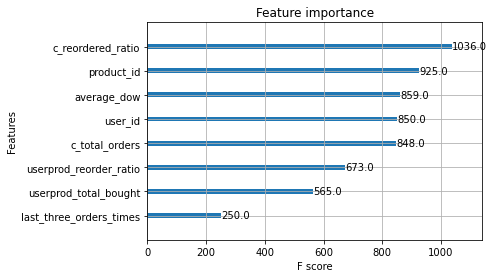

In [62]:
# Plot model to observe feature importance:
xgb.plot_importance(model)

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
 #TRIM 'data_train' to 10%

# data_train.reset_index(inplace=True)

trimmed_data_train = data_train.loc[data_train.user_id.isin(data_train.user_id.drop_duplicates().sample(frac=0.1, random_state=25))].set_index(['user_id', 'product_id'])

X_train, y_train = trimmed_data_train.drop('reordered', axis=1), trimmed_data_train.reordered

In [65]:
# Adjust Booster's parameters (range)

gridparam = {"max_depth":[5,10], 
             "colsample_bytree":[0.3, 0.4]}  

In [66]:
xgbc = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10)

In [67]:
gridsearch = GridSearchCV(xgbc, gridparam, cv=3, verbose=2)

================================================= test session starts =================================================
platform win32 -- Python 3.9.7, pytest-6.2.4, py-1.10.0, pluggy-0.13.1
rootdir: C:\Users\pramo\Documents\Pramod_Docs\Coursework\ADM\Final_Project_Proposal\notebooks
plugins: anyio-2.2.0
collected 46111 items / 11134 deselected / 34977 selected

_build_utils\tests\test_scipy_version.py .                                                                       [  0%]
_lib\tests\test__gcutils.py ......                                                                               [  0%]
_lib\tests\test__pep440.py .........                                                                             [  0%]
_lib\tests\test__testutils.py ..                                                                                 [  0%]
_lib\tests\test__threadsafety.py ..                                                                              [  0%]
_lib\tests\test__util.py ..........

................................................................................................................ [ 14%]
................................................................................................................ [ 14%]
................................................................................................................ [ 14%]
..................                                                                                               [ 15%]
fftpack\tests\test_basic.py ......x............................................................................. [ 15%]
................................................................................................................ [ 15%]
....................................................................................................             [ 15%]
fftpack\tests\test_helper.py ....                                                                                [ 15%]
fftpack\tests\test_import.py .          

linalg\tests\test_decomp_ldl.py .....                                                                            [ 22%]
linalg\tests\test_decomp_polar.py ..                                                                             [ 22%]
linalg\tests\test_decomp_update.py ............................................................................. [ 22%]
................................................................................................................ [ 22%]
................................................................................................................ [ 23%]
................................................................................................................ [ 23%]
................................................................................................................ [ 23%]
................................................................................................................ [ 24%]
............................            

................                                                                                                 [ 38%]
ndimage\tests\test_measurements.py ............................................................................. [ 38%]
..........................................                                                                       [ 38%]
ndimage\tests\test_morphology.py ............................................................................... [ 38%]
................................................................................................................ [ 38%]
................................................................................................................ [ 39%]
................................................................................................................ [ 39%]
................................................................................................................ [ 39%]
........................................

........................................................................................................         [ 46%]
signal\tests\test_fir_filter_design.py .................................                                         [ 46%]
signal\tests\test_ltisys.py .................................................................................... [ 47%]
...............                                                                                                  [ 47%]
signal\tests\test_max_len_seq.py ..                                                                              [ 47%]
signal\tests\test_peak_finding.py ................................................                               [ 47%]
signal\tests\test_result_type.py .....                                                                           [ 47%]
signal\tests\test_savitzky_golay.py ............                                                                 [ 47%]
signal\tests\test_signaltools.py .......

...........................................................sss..xx.............................................. [ 58%]
............................s.................................................................sss..xx........... [ 58%]
............................................................s......sssss.ssssssssssssssssssssssssssssssssssss... [ 59%]
...............xx.x.sssxx.ssssss...................................................................s......sssss. [ 59%]
ssssssssssssssssssssssssssssssssssss............x......sss..........ss.ss.................s......s...sssssssssss [ 59%]
ssssss.....sss.ss.....s..s.x................s..ss.................sssssxxs..sssss.s.s...........s.......ss.ss... [ 60%]
..........s.....s..ssssssssssssssssss....ssss.s..s...s..s.xsss..............ss.ss.................ssss..s..sssss [ 60%]
.s.s..............s....................................s....................................s................... [ 60%]
.....................s..............s...

spatial\tests\test_slerp.py .......................................................................              [ 76%]
spatial\tests\test_spherical_voronoi.py ........................................................................ [ 76%]
................................................                                                                 [ 76%]
spatial\transform\tests\test_rotation.py ....................................................................... [ 76%]
.....................                                                                                            [ 76%]
spatial\transform\tests\test_rotation_groups.py ................................................................ [ 77%]
................................................................................................................ [ 77%]
........................................................                                                         [ 77%]
spatial\transform\tests\test_rotation_sp

stats\tests\test_contingency.py ...........                                                                      [ 83%]
stats\tests\test_continuous_basic.py ........................................................................... [ 83%]
.....s....xx.......................................................................................s............ [ 84%]
.............................ss................................................................s................ [ 84%]
................................................................................................................ [ 84%]
................................................................................................................ [ 85%]
................................................................................................................ [ 85%]
................................................................................................................ [ 85%]
........................................

__________________________________________________ test_expi_complex __________________________________________________
C:\Users\pramo\anaconda3\lib\site-packages\scipy\special\tests\test_mpmath.py:44: in test_expi_complex
    FuncData(sc.expi, dataset, 0, 1).check()
E   AssertionError: 
E   Max |adiff|: 6.28319
E   Max |rdiff|: 0.304157
E   Bad results (9 out of 300) for the following points (in output 0):
E                       1.e-99+0.j => -227.37870854150898+6.283185307179586j !=        -227.37870854150898+0.j  (rdiff            0.02763312953742352)
E        1.668100537200083e-88+0.j => -201.5385869423536+6.283185307179586j !=        -201.53858694235356+0.j  (rdiff            0.03117609090400528)
E       2.7825594022071145e-77+0.j => -175.6984653431982+6.283185307179586j !=         -175.6984653431982+0.j  (rdiff            0.03576118490794107)
E       4.6415888336126776e-66+0.j => -149.8583437440428+6.283185307179586j !=         -149.8583437440428+0.j  (rdiff           0.04192749

False

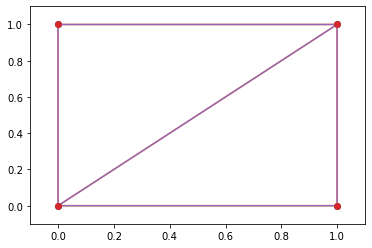

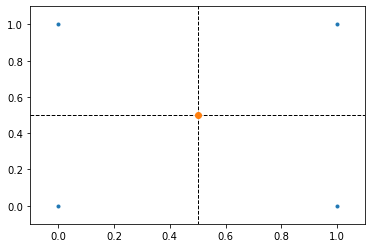

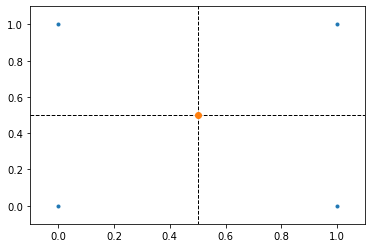

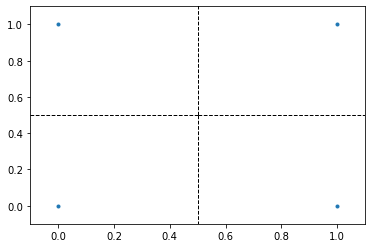

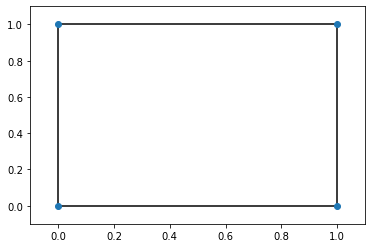

In [68]:
import scipy
scipy.test()

In [69]:
model_best = gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[22:15:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END ..................colsample_bytree=0.3, max_depth=5; total time=   4.5s
[22:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV] END ..

In [70]:
prediction_test = model_best.predict(data_test) #.astype(int)

In [71]:
prediction_test[20:40] # Display the first 10 predictions of numpy array

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
prediction_on_train = model_best.predict(X_train) #.astype(int)

In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_train, prediction_on_train))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95    759821
         1.0       0.64      0.17      0.27     82594

    accuracy                           0.91    842415
   macro avg       0.78      0.58      0.61    842415
weighted avg       0.89      0.91      0.89    842415



In [ ]:
import pickle
filename = 'finalized_model.pkl'
pickle.dump(model_best, open(filename, 'wb'))

# ANN Model

In [76]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler


In [77]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(data_test)

In [78]:
input_dim =  X_train_sc.shape[1]
input_dim

6

In [79]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [80]:
history = History()

classifier = Sequential()

classifier.add(Dense(units = 64, activation = 'relu', input_dim = input_dim))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 1, activation ='sigmoid'))

classifier.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ['accuracy', f1_m, precision_m, recall_m])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 15)                975       
                                                                 
 dense_2 (Dense)             (None, 4)                 64        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 1,492
Trainable params: 1,492
Non-trainable params: 0
_________________________________________________________________


In [81]:
%%time
# fit the model
classifier.fit(X_train_sc, y_train, epochs=50, batch_size=512, validation_split=0.15, verbose=1,class_weight= {0:1, 1:10},
          callbacks = [history, keras.callbacks.EarlyStopping(monitor='val_loss',
                                                              min_delta=0, patience=10, verbose=0, mode='auto')])

Epoch 1/50
1399/1399 [==============================] - 6s 2ms/step - loss: 1.0233 - accuracy: 0.6933 - f1_m: 0.3265 - precision_m: 0.2092 - recall_m: 0.7562 - val_loss: 0.5314 - val_accuracy: 0.7226 - val_f1_m: 0.3330 - val_precision_m: 0.2180 - val_recall_m: 0.7331
Epoch 2/50
1399/1399 [==============================] - 2s 2ms/step - loss: 0.9959 - accuracy: 0.7083 - f1_m: 0.3387 - precision_m: 0.2194 - recall_m: 0.7581 - val_loss: 0.4971 - val_accuracy: 0.7751 - val_f1_m: 0.3600 - val_precision_m: 0.2495 - val_recall_m: 0.6722
Epoch 3/50
1399/1399 [==============================] - 2s 2ms/step - loss: 0.9923 - accuracy: 0.7170 - f1_m: 0.3441 - precision_m: 0.2244 - recall_m: 0.7535 - val_loss: 0.5050 - val_accuracy: 0.7552 - val_f1_m: 0.3518 - val_precision_m: 0.2374 - val_recall_m: 0.7049
Epoch 4/50
1399/1399 [==============================] - 2s 2ms/step - loss: 0.9905 - accuracy: 0.7211 - f1_m: 0.3465 - precision_m: 0.2266 - recall_m: 0.7508 - val_loss: 0.5190 - val_accuracy: 0.7

In [82]:
eval_model=classifier.evaluate(X_train_sc, y_train)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])

26326/26326 [==============================] - 28s 1ms/step - loss: 0.5683 - accuracy: 0.7080 - f1_m: 0.2918 - precision_m: 0.2101 - recall_m: 0.6229
loss:  0.568274199962616 and Accuracy:  0.7080049514770508


Text(0.5, 1.0, 'Loss')

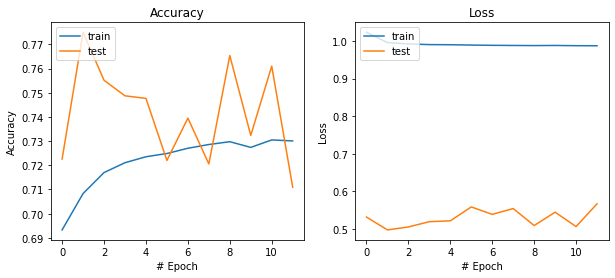

In [84]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

# Accuracy
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('# Epoch')
ax[0].legend(['train', 'test'], loc='upper left')
ax[0].set_title('Accuracy')

# Loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('# Epoch')
ax[1].legend(['train', 'test'], loc='upper left')
ax[1].set_title('Loss')